<a href="https://colab.research.google.com/github/ArashDehghanyan/Topic-modelling/blob/master/imdb_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mount your drive
from google.colab import drive

drive.mount('/MyDrive/')


Drive already mounted at /MyDrive/; to attempt to forcibly remount, call drive.mount("/MyDrive/", force_remount=True).


##Import all libraries

In [ ]:
import numpy as np
import pandas as pd
from nltk.stem import WordNetLemmatizer, PorterStemmer
from gensim.parsing.preprocessing import STOPWORDS
import gensim
from gensim.utils import simple_preprocess
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional,Flatten,Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import re
import tensorflow_hub as hub
import gc
stemmer = PorterStemmer()


In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
print("Tensorflow version:", tf.__version__)
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("Hub version:", hub.__version__)

Tensorflow version: 2.3.0
numpy version: 1.18.5
pandas version: 1.0.5
Hub version: 0.8.0


##Preprocess data

In [ ]:
def remove_special_chars(tweets): # it unrolls the hashtags to normal words
  for remove in map(lambda r: re.compile(re.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$",
                                                        "@", "%", "^", "*", "(", ")", "{", "}",
                                                        "[", "]", "|", "/", "\\", ">", "<", "-",
                                                        "!", "?", ".", "'",
                                                        " — ", " — -", "#"]):
    tweets.replace(remove, "", inplace=True)
  return tweets
def remove_tags(text):
 return re.compile(r'<[^>]+>').sub('', text)
def remove_num(text):
 return ''.join(re.sub(r"([0–9]+)","",text))
def lemmatize_stemmer(text):
  return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
  res = []
  for token in simple_preprocess(text):
    if token not in STOPWORDS and len(token)>3:
      res.append(lemmatize_stemmer(token))
  return res

data = pd.read_csv('/MyDrive/My Drive/IMDB Dataset.csv')
data.review=data.review.apply(lambda x : remove_tags(x))
data.review=data.review.apply(lambda x : remove_num(x))
data.review = remove_special_chars(data['review'])
lemmatizede_text = data.review.apply(lambda x: preprocess(x))
data.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production The filming tech...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically theres a family where a little boy J...,negative
4,Petter Matteis Love in the Time of Money is a ...,positive


In [ ]:
sentiments = data['sentiment'].values
positives = [pos for pos in sentiments if pos=='positive']
negatives = [neg for neg in sentiments if neg=='negative']

print('Ther are {} positive sentiment.'.format(len(positives)))
print('Ther are {} negative sentiment.'.format(len(negatives)))

Ther are 25000 positive sentiment.
Ther are 25000 negative sentiment.


In [ ]:
lemmatizede_text.head()

0    [review, mention, watch, episod, youll, hook, ...
1    [wonder, littl, product, film, techniqu, unass...
2    [think, wonder, spend, time, summer, weekend, ...
3    [basic, there, famili, littl, jake, think, the...
4    [petter, mattei, love, time, money, visual, st...
Name: review, dtype: object

##Tokenization

In [ ]:
import pickle

MAX_SEQ_LEN = 500
#Define Tokenizer
tokenizer = Tokenizer(num_words=5000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True, split=" ")

tokenizer.fit_on_texts(lemmatizede_text)
X = tokenizer.texts_to_sequences(lemmatizede_text)
X = pad_sequences(X, maxlen=MAX_SEQ_LEN, padding='post')
Y = data['sentiment']

vocab_size = len(tokenizer.word_index) + 1

# Split train and test sets
X_train, X_test , Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=24)

# Store tokenizer in a file to use later 

from sklearn.preprocessing import LabelEncoder
def prepare_targets(y_train, y_test):
  le = LabelEncoder()
  le.fit(y_train)
  y_train_enc = le.transform(y_train)
  y_test_enc = le.transform(y_test)
  return y_train_enc, y_test_enc

ytrain,ytest = prepare_targets(Y_train,Y_test)

In [ ]:
with open("tokenizer.pickle", 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
print(X_train.shape); print(X_test.shape); print(ytrain.shape); print(ytest.shape)

(35000, 500)
(15000, 500)
(35000,)
(15000,)


In [ ]:
def loadEmbeddingMatix(filename):
  """load embedding file of type word2vec from My Drive and
  create embedding matrix """
  import gc
  embed_size = 300
  embed_idx = dict()
    
  word2vecDict = gensim.models.KeyedVectors.load_word2vec_format(f'/MyDrive/My Drive/3/{filename}', binary=True, unicode_errors='ignore')
  for word in word2vecDict.wv.vocab:
    coefs = word2vecDict.word_vec(word)
    embed_idx[word.split('_')[0]] = coefs
  gc.collect()
  all_embed = np.stack(list(embed_idx.values()))
  embed_mean , embed_dev = all_embed.mean(), all_embed.std()
  nb_words = len(tokenizer.word_index)
  embed_mat = np.random.normal(embed_mean, embed_dev, (nb_words, embed_size))
  gc.collect()
  embed_counter = 0
  for word, i in tokenizer.word_index.items():
    i -= 1
    # we see if this word exists in embedding dictionary, if yes gets corresponding weights
    embed_vec = embed_idx.get(word)
    if embed_vec is not None:
      embed_mat[i] = embed_vec
      embed_counter += 1

  print(f"Total embedded: {embed_counter} common word!")
  del(embed_idx)
  gc.collect()

  return embed_mat

In [ ]:
embedding_matrix = loadEmbeddingMatix('model.bin')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':


Total embedded: 14415 common word!


##Pre-trained Word Embedding weights

In [ ]:
embedding_matrix.shape

(161008, 300)

##Normal model (1 hidden layer) with pre-trained word Embedding layer

In [ ]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, GlobalAveragePooling1D, Input
from tensorflow.keras.models import Model
input_layer = Input(shape = (MAX_SEQ_LEN, ))
embed = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],weights=[embedding_matrix], #input_length=MAX_SEQ_LEN
                  trainable=False)(input_layer)
x = Bidirectional(LSTM(128, return_sequences=True, name='lstm_layer'))(embed)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(60, activation='relu', name='hidden_1')(x)
x = Dropout(0.2)(x)

outs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[input_layer], outputs=[outs])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 300)          48302400  
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 256)          439296    
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 60)                15420     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)               

##Train model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#EarlyStopping Setting
es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
#CheckPoint setting
save_ckp = ModelCheckpoint('movie-sent-{epoch:03d}-{loss:0.2f}-{acc:0.2f}.h5',
                           verbose=1, monitor='val_loss', mode='min', save_best_only=True)
#Train model
hist = model.fit(X_train, ytrain,
                  batch_size=256,
                  epochs=30,
                  #validation_data=[X_test, ytest],
                 validation_split=0.2,
                  callbacks=[es, save_ckp],
                 verbose=1
                  )

#We save this model so that we can use in own web app
#model.save('movie_sent.h5')

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 0.6940 - acc: 0.5005
Epoch 00001: val_loss improved from inf to 0.69357, saving model to movie-sent-001-0.69-0.50.h5
110/110 [==============================] - 23s 211ms/step - loss: 0.6940 - acc: 0.5005 - val_loss: 0.6936 - val_acc: 0.4924
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 0.6933 - acc: 0.5000
Epoch 00002: val_loss improved from 0.69357 to 0.69294, saving model to movie-sent-002-0.69-0.50.h5
110/110 [==============================] - 23s 207ms/step - loss: 0.6933 - acc: 0.5000 - val_loss: 0.6929 - val_acc: 0.5199
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 0.6932 - acc: 0.5058
Epoch 00003: val_loss improved from 0.69294 to 0.69279, saving model to movie-sent-003-0.69-0.51.h5
110/110 [==============================] - 23s 210ms/step - loss: 0.6932 - acc: 0.5058 - val_loss: 0.6928 - val_acc: 0.5084
Epoch 4/30
110/110 [==============================] - ETA: 

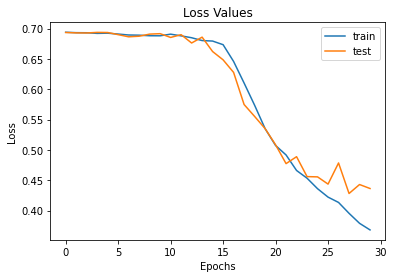

In [ ]:
# Visualize training trace
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Values')
plt.legend(['train', 'test'], loc='best')

##Test with your own reviews

In [ ]:
string11='''Between the Lovecraftian overtones and Liberato’s performance, 
The Beach House offers up beautifully shot terror and will make you think before opening your door.'''
x_1=tokenizer.texts_to_sequences([string11])
x_1 = pad_sequences(x_1, maxlen=500)
model.predict(x_1)[0][0]

0.55551064

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('movie-sent-028-0.40-0.82.h5')
loaded_model.predict(x_1)[0][0]

0.5372828

In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score

y_hat = model.predict(X_test)
yhat = [x>0.6 for x in y_hat]
prec = precision_score(y_true=ytest, y_pred=yhat); print(f'precision_score = {prec:.2f}')
recal = recall_score(ytest, yhat); print(f"recall_score = {recal:.2f}")
f_one = f1_score(ytest, yhat); print(f"f1_score = {f_one:.2f}")

precision_score = 0.78
recall_score = 0.86
f1_score = 0.82


In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score

y_hat = loaded_model.predict(X_test)
yhat = [x>0.6 for x in y_hat]
precision = precision_score(y_true=ytest, y_pred=yhat)
recall = recall_score(ytest, yhat)
f1 = f1_score(ytest, yhat)
print("precision score = {:.2f}\nrecall score = {:.2f}\nf1 score = {:.2f}".format(precision, recall, f1))

precision score = 0.80
recall score = 0.81
f1 score = 0.81


##Normal model (1 hidden layer) without pre-trsined word Embedding layer

In [ ]:
from tensorflow.keras.models import Sequential
seq_model = Sequential()
seq_model.add(Embedding(len(tokenizer.word_index), 300, input_length=MAX_SEQ_LEN))
seq_model.add(Bidirectional(LSTM(128, name='lstm_layer')))
seq_model.add(Dropout(0.2))
seq_model.add(Dense(60, activation='relu', name='dense_1'))
seq_model.add(Dropout(0.2))
seq_model.add(Dense(1,activation='sigmoid', name='output_layer'))
seq_model.compile(optimizer='adam',
              loss='binary_crossentropy', metrics=['acc'])
seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 300)          48302400  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               439296    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                15420     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60)                0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 61        
Total params: 48,757,177
Trainable params: 48,757,177
Non-trainable params: 0
__________________________________________

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from time import time
import gc
save = ModelCheckpoint('movie_sent_seq.h5',
                           verbose=1, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
start = time()
history=seq_model.fit(X_train, ytrain,
                      batch_size=256,
                      epochs=30,
                      validation_split=0.2,
                      #validation_data=[X_test, ytest],
                      callbacks=[es, save]
                      )
print("Total training time:%.1f"%(time() - start))

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 0.5447 - acc: 0.7325
Epoch 00001: val_loss improved from inf to 0.35470, saving model to movie_sent_seq.h5
110/110 [==============================] - 73s 667ms/step - loss: 0.5447 - acc: 0.7325 - val_loss: 0.3547 - val_acc: 0.8540
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 0.2944 - acc: 0.8841
Epoch 00002: val_loss improved from 0.35470 to 0.31885, saving model to movie_sent_seq.h5
110/110 [==============================] - 73s 660ms/step - loss: 0.2944 - acc: 0.8841 - val_loss: 0.3189 - val_acc: 0.8750
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 0.2381 - acc: 0.9091
Epoch 00003: val_loss did not improve from 0.31885
110/110 [==============================] - 70s 639ms/step - loss: 0.2381 - acc: 0.9091 - val_loss: 0.3206 - val_acc: 0.8714
Epoch 4/30
110/110 [==============================] - ETA: 0s - loss: 0.2043 - acc: 0.9249
Epoch 00004: val_loss did not improve

In [ ]:
string11='''Between the Lovecraftian overtones and Liberato’s performance, 
The Beach House offers up beautifully shot terror and will make you think before opening your door.'''
x_1=tokenizer.texts_to_sequences([string11])
x_1 = pad_sequences(x_1, maxlen=500)
seq_model.predict(x_1)[0][0]

0.37485853

In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score

y_hat = seq_model.predict(X_test)
yhat = [x>0.6 for x in y_hat]
precision = precision_score(y_true=ytest, y_pred=yhat)
recall = recall_score(ytest, yhat)
f1 = f1_score(ytest, yhat)
print("precision score = {:.2f}\nrecall score = {:.2f}\nf1 score = {:.2f}".format(precision, recall, f1))

precision score = 0.84
recall score = 0.86
f1 score = 0.85


##Little model neither hidden layer (just lstm & output) and pre-trained word embedding

In [ ]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, GlobalAveragePooling1D, Input
from tensorflow.keras.models import Model

input_layer = Input(shape = (MAX_SEQ_LEN, ))

embed = Embedding(len(tokenizer.word_index), 300, )(input_layer)
x = Bidirectional(LSTM(128, name='lstm_layer'))(embed)
x = Dropout(0.2)(x)

outs = Dense(1, activation='sigmoid')(x)

little_model = Model(inputs=[input_layer], outputs=[outs])
little_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
little_model.summary()


Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 500, 300)          48302400  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               439296    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 48,741,953
Trainable params: 48,741,953
Non-trainable params: 0
_________________________________________________________________


##Customized training method

In [ ]:
def trainModel(model=None,x=None, y=None, modelName=None, esMonitor='val_loss', esMode='min', patience=5, ckpMonitor='val_loss', ckpMode='min', 
               saveBestOnly=True, validation_data=None, validation_split=0.0, batch_size=1, iteration=1, verbose=1):
  """define a custom training method using Earlystopping and ModelCheckpoint,
  then save the best model and also total training time, then return the best model and 
  plots training history"""

  import tensorflow_hub as hub
  from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
  from tensorflow.keras.models import load_model
  from time import time
  import gc
  
  #check if model is empty
  if model is None:
    raise ValueError("You must enter a model object to train, it cannot be empty!")

  #check if x & y is enetred
  if x is None:
    #("Please enter learning data ...")
    raise ValueError("Training data have missed! please enter X_train.")
  
  if y is None:
    raise ValueError("Please enter target data ...")

  if modelName is None:
    raise ValueError("Please enter model name to save trained best model!")

  # define EarlyStopping 
  es = EarlyStopping(monitor=esMonitor, mode=esMode, verbose=verbose, patience=patience)
  #CheckPoint setting
  save = ModelCheckpoint(modelName,
                            verbose=verbose, monitor=ckpMonitor, mode=ckpMode, 
                             save_best_only=saveBestOnly)
  #Train model
  start = time()
  hist = model.fit(x, y,
                    batch_size=batch_size,
                    epochs=iteration,
                    validation_data=validation_data,
                    validation_split=validation_split,
                    callbacks=[es, save],
                    verbose=verbose
                    )
  training_period = time() - start
  print(f"Trained in {training_period :.1f} seconds.")

  del(es, save)
  gc.collect()
  #checks if is there a Keras_Layer in the model
  is_keras_layer = False
  for x in model.layers[::-1]:
    if isinstance(x, hub.KerasLayer):
      is_keras_layer = True
      model = load_model(modelName, custom_objects={'KerasLayer':hub.KerasLayer})

  if not is_keras_layer:
    model = load_model(modelName)
  return [model, hist]

In [ ]:
little_model, hist = trainModel(little_model, X_train, ytrain, 'movie_sent_little.h5', validation_split=0.2, batch_size=256, iteration=30)

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 0.4860 - acc: 0.7652
Epoch 00001: val_loss improved from inf to 0.34052, saving model to movie_sent_little.h5
110/110 [==============================] - 74s 674ms/step - loss: 0.4860 - acc: 0.7652 - val_loss: 0.3405 - val_acc: 0.8636
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 0.2835 - acc: 0.8887
Epoch 00002: val_loss improved from 0.34052 to 0.30996, saving model to movie_sent_little.h5
110/110 [==============================] - 73s 659ms/step - loss: 0.2835 - acc: 0.8887 - val_loss: 0.3100 - val_acc: 0.8761
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 0.2388 - acc: 0.9072
Epoch 00003: val_loss did not improve from 0.30996
110/110 [==============================] - 71s 641ms/step - loss: 0.2388 - acc: 0.9072 - val_loss: 0.3252 - val_acc: 0.8704
Epoch 4/30
110/110 [==============================] - ETA: 0s - loss: 0.2046 - acc: 0.9223
Epoch 00004: val_loss did not i

In [ ]:
def visualization(hist):
  import matplotlib.pyplot as plt

  plt.plot(hist.history['loss'], label='train')
  plt.plot(hist.history['val_loss'], label='test')
  plt.title('Loss')
  plt.xlabel('epochs')
  plt.legend()
  plt.show()
  plt.plot(hist.history['acc'], label='train')
  plt.plot(hist.history['val_acc'], label='test')
  plt.legend()
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.show()

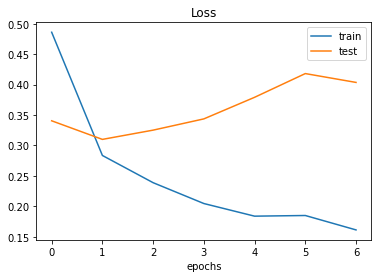

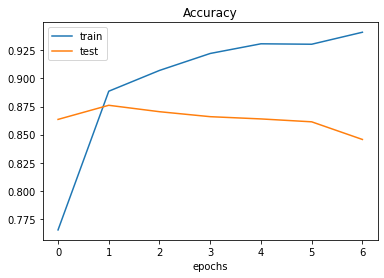

In [ ]:
visualization(hist)

In [ ]:
string11='''Between the Lovecraftian overtones and Liberato’s performance, 
The Beach House offers up beautifully shot terror and will make you think before opening your door.'''
x_1=tokenizer.texts_to_sequences([string11])
x_1 = pad_sequences(x_1, maxlen=500, padding='post')
little_model.predict(x_1)[0][0]

0.43343645

In [ ]:


from sklearn.metrics import recall_score, precision_score, f1_score

y_hat = little_model.predict(X_test)
yhat = [x>0.6 for x in y_hat]
precision = precision_score(y_true=ytest, y_pred=yhat)
recall = recall_score(ytest, yhat)
f1 = f1_score(ytest, yhat)
print("precision score = {:.2f}\nrecall score = {:.2f}\nf1 score = {:.2f}".format(precision, recall, f1))

precision score = 0.88
recall score = 0.85
f1 score = 0.87


##Extended model (2 lstm & 2 hidden layers) with pre-trained word Embedding layer

In [ ]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, GlobalAveragePooling1D, Input
from tensorflow.keras.models import Model

input_layer = Input(shape = (MAX_SEQ_LEN, ))

embed = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],
                  weights=[embedding_matrix], trainable=False)(input_layer)

x = Bidirectional(LSTM(256, return_sequences=True, name='lstm_1'))(embed)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(128, return_sequences=True, name='lstm_2'))(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)

x = Dense(256, activation='relu', name='dense_1')(x) # 1st hidden layer
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', name='dense_2')(x)
x = Dropout(0.2)(x)
# output layer
outs = Dense(1, activation='sigmoid')(x)
# Model defenition
extended_model = Model(inputs=[input_layer], outputs=[outs])
extended_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
extended_model.summary()


Model: "functional_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 500, 300)          48302400  
_________________________________________________________________
bidirectional_8 (Bidirection (None, 500, 512)          1140736   
_________________________________________________________________
dropout_14 (Dropout)         (None, 500, 512)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 500, 256)          656384    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 256)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)              

In [ ]:
extended_model, hist = trainModel(extended_model, X_train, ytrain, 'movie_sent_little.h5', validation_split=0.2, batch_size=256, iteration=30)

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 0.6951 - acc: 0.4965
Epoch 00001: val_loss improved from inf to 0.69463, saving model to movie_sent_little.h5
110/110 [==============================] - 82s 747ms/step - loss: 0.6951 - acc: 0.4965 - val_loss: 0.6946 - val_acc: 0.4924
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 0.6933 - acc: 0.5124
Epoch 00002: val_loss improved from 0.69463 to 0.69279, saving model to movie_sent_little.h5
110/110 [==============================] - 75s 679ms/step - loss: 0.6933 - acc: 0.5124 - val_loss: 0.6928 - val_acc: 0.5076
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 0.6930 - acc: 0.5131
Epoch 00003: val_loss improved from 0.69279 to 0.69197, saving model to movie_sent_little.h5
110/110 [==============================] - 74s 672ms/step - loss: 0.6930 - acc: 0.5131 - val_loss: 0.6920 - val_acc: 0.5221
Epoch 4/30
110/110 [==============================] - ETA: 0s - loss: 0.6927 - a

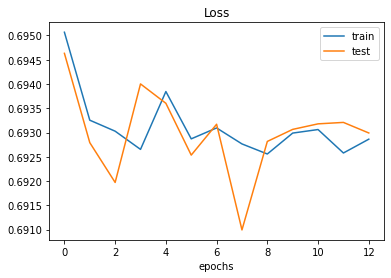

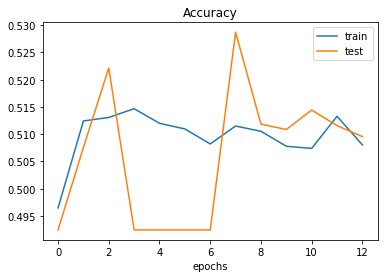

In [ ]:
visualization(hist)

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score


y_hat = extended_model.predict(X_test)
yhat = [x>0.6 for x in y_hat]
prec = precision_score(ytest, yhat)
recal = recall_score(ytest, yhat)
f_one = f1_score(ytest, yhat)
print("precision score = {:.2f}".format(prec))
print("recall score = {:.2f}".format(recal))
print("f1 score = {:.2f}".format(f_one))

precision score = 0.78
recall score = 0.00
f1 score = 0.00


In [ ]:
string11='''Between the Lovecraftian overtones and Liberato’s performance, 
The Beach House offers up beautifully shot terror and will make you think before opening your door.'''
x_1=tokenizer.texts_to_sequences([string11])
x_1 = pad_sequences(x_1, maxlen=500, padding='post')
extended_model.predict(x_1)[0][0]

0.52279735

#Compare with BERT model

##Install prerequisites to use BERT

In [ ]:
!pip install bert-for-tf2
!pip install sentencepiece

In [ ]:
import tensorflow_hub as hub
import bert

print("Tensoflow version:", tf.__version__)
print("Hub version:", hub.__version__)
print("BERT version:", bert.__version__)

Tensoflow version: 2.3.0
Hub version: 0.8.0
BERT version: 0.14.5


##Sentiment Analysis using BERT
#Importing BERT Layer

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

hub_url = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
embed = hub.KerasLayer(hub_url)
embeddings = embed(["A long sentence.", "single-word", "http://example.com"])
print(embeddings.shape, embeddings.dtype)

(3, 128) <dtype: 'float32'>


(array([4.9700e+03, 1.9726e+04, 1.0641e+04, 5.3500e+03, 3.2530e+03,
        1.9670e+03, 1.3650e+03, 8.6300e+02, 6.0600e+02, 4.2500e+02,
        3.0800e+02, 2.6900e+02, 1.9800e+02, 3.0000e+01, 5.0000e+00,
        8.0000e+00, 2.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   30. ,   471.9,   913.8,  1355.7,  1797.6,  2239.5,  2681.4,
         3123.3,  3565.2,  4007.1,  4449. ,  4890.9,  5332.8,  5774.7,
         6216.6,  6658.5,  7100.4,  7542.3,  7984.2,  8426.1,  8868. ,
         9309.9,  9751.8, 10193.7, 10635.6, 11077.5, 11519.4, 11961.3,
        12403.2, 12845.1, 13287. ]),
 <a list of 30 Patch objects>)

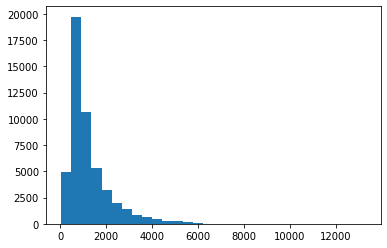

In [ ]:
import matplotlib.pyplot as plt
rev_len = [len(rev) for rev in data.review]
plt.hist(rev_len, bins=30)

In [ ]:
import numpy as np

print("max length = {}".format(max(rev_len)))
print("mean length = {:.1f}".format(np.mean(rev_len)))
print("median length = {:.2f}".format(np.median(rev_len)))

max length = 13287
mean length = 1243.7
median length = 922.00


In [ ]:
def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))
 
def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [ ]:
MAX_SEQ_LEN = 500
# Define BERT layer inputs
input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="input_word_ids")
 
input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="input_mask")
 
segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                    name="segment_ids")
# Define BERT
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/2", trainable=False)
# define BERT outputs
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [ ]:
# BERT Tokenizer
FullTokenizer=bert.bert_tokenization.FullTokenizer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
                                      
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

bert_tokenizer=FullTokenizer(vocab_file,do_lower_case)

In [ ]:
import pickle

with open("bert_tokenizer.pickle", 'wb') as handle:
  pickle.dump(bert_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
def create_single_input(sentence,MAX_LEN):
  
  stokens = bert_tokenizer.tokenize(sentence)
  
  stokens = stokens[:MAX_LEN]
  
  stokens = ["[CLS]"] + stokens + ["[SEP]"]
 
  ids = get_ids(stokens, bert_tokenizer, MAX_SEQ_LEN)
  masks = get_masks(stokens, MAX_SEQ_LEN)
  segments = get_segments(stokens, MAX_SEQ_LEN)
 
  return ids,masks,segments

from tqdm import tqdm 
def create_input_array(sentences):
 
  input_ids, input_masks, input_segments = [], [], []
 
  for sentence in tqdm(sentences,position=0, leave=True):
  
    ids,masks,segments=create_single_input(sentence,MAX_SEQ_LEN-2)
 
    input_ids.append(ids)
    input_masks.append(masks)
    input_segments.append(segments)
 
  return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)]

In [ ]:
# Split dataset to train and test data
from sklearn.model_selection import train_test_split
#Y = data.sentiment
X_t, X_val, Y_t, Y_val = train_test_split(data.review, Y, test_size=0.3, random_state=24)

# Prepare inputs
x_t = create_input_array(X_t)
x_val = create_input_array(X_val)

# Label Encoding the target
y_t, y_val = prepare_targets(Y_t, Y_val)

print("X_train shape =",X_t.shape); print("X_test shape =", X_val.shape)
print("Y_train shape =", y_t.shape); print("Y_test shape =", y_val.shape)

100%|██████████| 15000/15000 [00:57<00:00, 260.54it/s]


X_train shape = (35000,)
X_test shape = (15000,)
Y_train shape = (35000,)
Y_test shape = (15000,)


##Fine tune BERT_Basic model by just 1 hidden layer

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.models import Model

x = GlobalAveragePooling1D()(sequence_output)
x = Dense(60, activation='relu', name='dense_1')(x)
x = Dropout(0.1)(x)
out = Dense(1, activation='sigmoid', name='output_dense')(x)

bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

bert_model.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['acc'],
                   )

bert_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 500)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 500)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

##Train BERT model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#EarlyStopping Setting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
#CheckPoint setting
save_ckp = ModelCheckpoint('bert-{epoch:03d}-{loss:0.2f}-{acc:0.2f}.h5',
                           verbose=1, monitor='val_loss', mode='min', save_best_only=True)

from time import time
start = time()
h = bert_model.fit(x_t, y_t, batch_size=128, epochs=5,
                   validation_data=[x_val, y_val], shuffle=True,
                   callbacks=[es, save_ckp],
                   )
period = time() - start
print("Training Time = {:.2f} seconds".format(period))

Epoch 1/5
274/274 [==============================] - ETA: 0s - loss: 0.3978 - acc: 0.8258
Epoch 00001: val_loss improved from inf to 0.00000, saving model to bert-001-0.40-0.83.h5
274/274 [==============================] - 1595s 6s/step - loss: 0.3978 - acc: 0.8258 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/5
274/274 [==============================] - ETA: 0s - loss: 0.3255 - acc: 0.8607
Epoch 00002: val_loss did not improve from 0.00000
274/274 [==============================] - 1595s 6s/step - loss: 0.3255 - acc: 0.8607 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 3/5
274/274 [==============================] - ETA: 0s - loss: 0.3154 - acc: 0.8666
Epoch 00003: val_loss did not improve from 0.00000
274/274 [==============================] - 1591s 6s/step - loss: 0.3154 - acc: 0.8666 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 00003: early stopping
Training Time = 4805.53 seconds


In [ ]:
#Copy saved model to drive
!cp '/content/bert-001-0.34-0.85.h5' '/content/drive/My Drive/bert_model.h5'

In [ ]:
# Stor bert tokenizer
with open("bert_tokenizer.pickle", 'wb') as f:
  pickle.dump(bert_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
string11='''Between the Lovecraftian overtones and Liberato’s performance, 
The Beach House offers up beautifully shot terror and will make you think before opening your door.'''
x_1 = create_input_array([string11])
pred = bert_model.predict(x_1)
pred

100%|██████████| 1/1 [00:00<00:00, 443.70it/s]


array([[0.96545935]], dtype=float32)

In [ ]:
#Evaluate classification problem
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
PRED = tqdm(bert_model.predict(x_val), position=0, )
Y_hat = [j>0.6 for j in tqdm(PRED, position=0, leave=True)]

_precision = precision_score(y_val, Y_hat)
_recall = recall_score(y_val, Y_hat)
_f1 = f1_score(y_val, Y_hat)



100%|██████████| 15000/15000 [00:00<00:00, 531781.69it/s]


In [ ]:
print("Precision Score={:.2f}\nRecallScore={:.2f}\nf1 score={:.2f}".format(_precision, _recall, _f1))

Precision Score=0.91
RecallScore=0.79
f1 score=0.85


##BERT_Basic fine tuning without hidden layer

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.models import Model

x = GlobalAveragePooling1D()(sequence_output)
#x = Dense(60, activation='relu', name='dense_1')(x)
#x = Dropout(0.1)(x)
out = Dense(1, activation='sigmoid', name='output_dense')(x)

new_bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

new_bert_model.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['acc'],
                   )

new_bert_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 500)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 500)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#EarlyStopping Setting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
#CheckPoint setting
save_ckp = ModelCheckpoint('bert-{epoch:03d}-{loss:0.2f}-{acc:0.2f}.h5',
                           verbose=0, monitor='val_loss', mode='min', save_best_only=True)

from time import time
start = time()
h = new_bert_model.fit(x_t, y_t, batch_size=32, epochs=1, verbose=1,
                   validation_data=[x_val, y_val], shuffle=True,
                   callbacks=[es, save_ckp],
                   )
period = time() - start
print("Training Time = {:.2f} seconds".format(period))


Epoch 00001: val_loss improved from inf to 0.00000, saving model to bert-001-0.45-0.82.h5
1094/1094 - 1538s - loss: 0.4485 - acc: 0.8187 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Training Time = 1539.60 seconds


In [ ]:
#Evaluate classification problem
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
PRED = tqdm(new_bert_model.predict(x_val))
Y_hat = [j>0.6 for j in tqdm(PRED, position=0, leave=True)]

_precision = precision_score(y_val, Y_hat)
_recall = recall_score(y_val, Y_hat)
_f1 = f1_score(y_val, Y_hat)

print("\nPrecision Score={:.2f}\nRecallScore={:.2f}\nf1 score={:.2f}".format(_precision, _recall, _f1))

100%|██████████| 15000/15000 [00:00<00:00, 429949.84it/s]

Precision Score=0.92
RecallScore=0.72
f1 score=0.81


##BERT_Large fine tuning without hidden layer

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.models import Model

x = GlobalAveragePooling1D()(sequence_output)
#x = Dense(60, activation='relu', name='dense_1')(x)
#x = Dropout(0.1)(x)
out = Dense(1, activation='sigmoid', name='output_dense')(x)

large_bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

large_bert_model.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['acc'],
                   )

large_bert_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 500)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 500)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
print(x_t[0].shape)

(35000, 500)


In [ ]:
'''from time import time
start = time()

h = large_bert_model.fit(x_t, y_t, batch_size=16, epochs=1, verbose=1,
                   #validation_data=[x_val, y_val],
                   #validation_split=0.2,
                   #callbacks=[es, save_ckp],
                   )
period = time() - start
print("Training Time = {:.2f} seconds".format(period))
'''
large_bert_model, hist = trainModel(large_bert_model, x_t, y_t, 'bert-large.h5', validation_split=0.2, batch_size=32, iteration=1)

   2/3500 [..............................] - ETA: 53:00 - loss: 0.7002 - acc: 0.5625WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.4462s vs `on_train_batch_end` time: 1.3724s). Check your callbacks.


2075/3500 [================>.............] - ETA: 44:18 - loss: 0.3743 - acc: 0.8528

KeyboardInterrupt: ignored

In [ ]:
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
PRED = large_bert_model.predict(x_val)
Y_hat = [j>0.6 for j in PRED]

_precision = precision_score(y_val, Y_hat)
_recall = recall_score(y_val, Y_hat)
_f1 = f1_score(y_val, Y_hat)

print("\nPrecision Score={:.2f}\nRecallScore={:.2f}\nf1 score={:.2f}".format(_precision, _recall, _f1))

KeyboardInterrupt: ignored

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.models import Model

x = GlobalAveragePooling1D()(sequence_output)
x = Dense(30, activation='relu', name='dense_1')(x)
x = Dropout(0.1)(x)
out = Dense(1, activation='sigmoid', name='output_dense')(x)

large_bert_h = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

large_bert_h.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['acc'],
                   )

large_bert_h.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 1000)]       0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 1000)]       0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 1000)]       0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
sequence_output.shape

TensorShape([None, 1000, 1024])

In [ ]:
from time import time
start = time()
h = large_bert_h.fit(x_t, y_t, batch_size=32, epochs=1, verbose=1,
                   validation_split=0.1, shuffle=True,
                   #callbacks=[es, save_ckp],
                   )
period = time() - start
print("Training Time = {:.2f} seconds".format(period))

InvalidArgumentError: ignored

In [ ]:
#Evaluate classification problem
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
PRED = tqdm(large_bert_h.predict(x_val))
Y_hat = [j>0.6 for j in tqdm(PRED, position=0, leave=True)]

_precision = precision_score(y_val, Y_hat)
_recall = recall_score(y_val, Y_hat)
_f1 = f1_score(y_val, Y_hat)

print("\nPrecision Score={:.2f}\nRecallScore={:.2f}\nf1 score={:.2f}".format(_precision, _recall, _f1))

100%|██████████| 15000/15000 [00:00<00:00, 458520.83it/s]


Precision Score=0.90
RecallScore=0.74
f1 score=0.81


In [ ]:
import gc 

gc.collect()

0

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.models import Model

x = GlobalAveragePooling1D()(sequence_output)
x = Dense(100, activation='relu', name='dense_1')(x)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu', name='dense_2')(x)
x = Dropout(0.5)(x)
x = Dense(20, activation='relu', name='danse_3')(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='relu', name='daense_4')(x)
x = Dropout(0.2)(x)

out = Dense(1, activation='sigmoid', name='output_layer')(x)

large_bert_hh = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

large_bert_hh.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['acc'],
                   )

large_bert_hh.summary()

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 500)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 500)]        0                                            
__________________________________________________________________________________________________
keras_layer_4 (KerasLayer)      [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]     

In [ ]:
from time import time
start = time()
hist = large_bert_hh.fit(x_t, y_t, batch_size=32, epochs=1, verbose=1,
                   validation_split=0.1, shuffle=True,
                   #callbacks=[es, save_ckp],
                   )
period = time() - start
print("Training Time = {:.2f} seconds".format(period))

985/985 [==============================] - ETA: 0s - loss: 0.4760 - acc: 0.7687

In [ ]:
#Evaluate classification problem
from tqdm import tqdm
from time import time
from sklearn.metrics import precision_score, recall_score, f1_score

start = time()
PRED = large_bert_hh.predict(x_val)
predict_time = time() - start
print("\nPredict time ={:.2f}".format(predict_time))

start = time()
Y_hat = [j>0.6 for j in PRED]
print("\nEncoding time ={:.2f}".format(time() - start))

_precision = precision_score(y_val, Y_hat)
_recall = recall_score(y_val, Y_hat)
_f1 = f1_score(y_val, Y_hat)

print("\nPrecision Score={:.2f}\nRecallScore={:.2f}\nf1 score={:.2f}".format(_precision, _recall, _f1))


Predict time ={predict_time:.2f}

Encoding time ={time()-start:.2f}

Precision Score=0.91
RecallScore=0.88
f1 score=0.89
